In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import optuna
import joblib
import os

# Configuración para visualización
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("viridis")
os.makedirs('resultados_ayuda', exist_ok=True)

# Función para cargar y preparar los datos
def load_data(file_path):
    df = pd.read_csv(file_path)
    
    # Verificar y gestionar valores faltantes
    print(f"Valores faltantes en el dataset: {df.isnull().sum().sum()}")
    
    # Identificar columnas categóricas automáticamente (si es necesario)
    categorical_features = []
    for col in df.columns:
        if df[col].dtype == 'object' or col in ['tipo_edificacion', 'calidade_materiais', 
                                               'cor_favorita_propietario', 'acceso_transporte_publico',
                                               'orientacion', 'eficiencia_enerxetica']:
            categorical_features.append(col)
    
    print(f"Características categóricas detectadas: {categorical_features}")
    
    # Separamos features y target
    X = df.drop(['prezo_euros', 'id'], axis=1, errors='ignore')
    y = df['prezo_euros']
    
    print(f"Forma del dataset: {df.shape}")
    print(f"Features incluidas: {X.columns.tolist()}")
    
    return X, y, categorical_features

# FASE 1: Entrenamiento base y análisis
def train_initial_model(X, y, cat_features=None, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=random_state
    )
    
    # Parámetros iniciales

    """
    
    initial_params = {
        'iterations': 1000,
        'learning_rate': 0.05,
        'depth': 6,
        'loss_function': 'MAE',
        'eval_metric': 'MAE',
        'random_seed': random_state,
        'verbose': 200
    }
    """

    initial_params = {
        'iterations': 4000,
        'learning_rate': 0.05,
        'depth': 3,
        'loss_function': 'MAE',
        'eval_metric': 'MAE',
        'random_seed': random_state,
        'verbose': 200
    }
    
    
    print("\n=== Entrenando modelo inicial para análisis ===")
    
    # Crear pool de datos para CatBoost
    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    test_pool = Pool(X_test, y_test, cat_features=cat_features)
    
    # Entrenar modelo
    model = CatBoostRegressor(**initial_params)
    model.fit(train_pool, eval_set=test_pool, use_best_model=True)
    
    # Evaluar modelo
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"Métricas del modelo inicial:")
    print(f"  MAE: {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R2: {r2:.4f}")
    
    # Analizar importancia de características
    feature_importance = model.get_feature_importance()
    feature_names = X.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Top 20 características más importantes', fontsize=15)
    plt.tight_layout()
    plt.savefig('resultados_ayuda/initial_feature_importance.png')
    
    print("\nAnálisis de características completado - Ver 'resultados_ayuda/initial_feature_importance.png'")
    
    # Devolver todo lo necesario para optimización
    return model, X_train, X_test, y_train, y_test, cat_features, importance_df

# FASE 2: Optimización con Grid Search
def optimize_with_grid_search(X_train, y_train, X_test, y_test, cat_features=None, random_state=42):
    print("\n=== Optimización con Grid Search ===")
    
    # Grid de parámetros a evaluar
    param_grid = {
        'iterations': [800],
        'learning_rate': [0.1,0.05,0.01],
        'depth': [2,4,10],
        'l2_leaf_reg': [1],
        'border_count': [64,128],
        'bagging_temperature': [0,1,5]
    }
    
    # Crear pool para entrenamiento
    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    
    # Configurar modelo base para GridSearch
    base_model = CatBoostRegressor(
        loss_function='MAE',
        eval_metric='MAE',
        random_seed=random_state,
        verbose=100
    )
    
    # Configurar GridSearchCV
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=3,  # Usar validación cruzada con 3 folds
        scoring='neg_mean_absolute_error',
        n_jobs=-1,  # Usar todos los núcleos disponibles
        verbose=1
    )
    
    # Entrenar Grid Search
    start_time = time.time()
    grid_search.fit(X_train, y_train, cat_features=cat_features)
    gs_time = time.time() - start_time
    
    # Mejores parámetros y resultados_ayuda
    print(f"Tiempo de Grid Search: {gs_time:.2f} segundos")
    print(f"Mejor MAE encontrado: {-grid_search.best_score_:.2f}")
    print(f"Mejores parámetros: {grid_search.best_params_}")
    
    # Evaluar mejor modelo en conjunto de prueba
    best_gs_model = grid_search.best_estimator_
    y_pred = best_gs_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"MAE en conjunto de prueba: {mae:.2f}")
    
    # Guardar resultados_ayuda
    gs_results = pd.DataFrame(grid_search.cv_results_)
    gs_results.to_csv('resultados_ayuda/grid_search_results.csv', index=False)
    
    return best_gs_model, grid_search.best_params_

# FASE 3: Optimización con Optuna
def optimize_with_optuna(X_train, y_train, X_test, y_test, cat_features=None, n_trials=3, random_state=42):
    print("\n=== Optimización con Optuna ===")
    
    # Crear función objetivo para Optuna
    def objective(trial):
        param = {
            'iterations': trial.suggest_int('iterations', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
            'depth': trial.suggest_int('depth', 4, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10.0, log=True),
            'random_strength': trial.suggest_float('random_strength', 0.1, 10.0, log=True),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']), 
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
            'loss_function': 'MAE',
            'eval_metric': 'MAE',
            'verbose': 0,
            'random_seed': random_state
        }
        
        # K-fold cross-validation
        kf = KFold(n_splits=3, shuffle=True, random_state=random_state)
        scores = []
        
        for train_idx, val_idx in kf.split(X_train):
            X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            train_pool = Pool(X_fold_train, y_fold_train, cat_features=cat_features)
            val_pool = Pool(X_fold_val, y_fold_val, cat_features=cat_features)
            
            model = CatBoostRegressor(**param)
            model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, verbose=0)
            
            preds = model.predict(X_fold_val)
            mae = mean_absolute_error(y_fold_val, preds)
            scores.append(mae)
        
        return np.mean(scores)
    
    # Crear estudio de Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)
    
    # Mejores parámetros
    best_params = study.best_params
    best_params['iterations'] = int(best_params['iterations'])
    best_params['depth'] = int(best_params['depth'])
    best_params['border_count'] = int(best_params['border_count'])
    best_params['min_data_in_leaf'] = int(best_params['min_data_in_leaf'])
    best_params['loss_function'] = 'MAE'
    best_params['eval_metric'] = 'MAE'
    best_params['verbose'] = 200
    best_params['random_seed'] = random_state
    
    print(f"Mejor valor de MAE encontrado: {study.best_value:.4f}")
    print(f"Mejores parámetros: {best_params}")
    
    # Entrenar modelo final con los mejores parámetros
    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    test_pool = Pool(X_test, y_test, cat_features=cat_features)
    
    final_model = CatBoostRegressor(**best_params)
    final_model.fit(train_pool, eval_set=test_pool, use_best_model=True)
    
    # Evaluar en conjunto de prueba
    y_pred = final_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"Métricas del modelo final:")
    print(f"  MAE: {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R2: {r2:.4f}")
    
    # Guardar análisis de importancia de características
    #visualize_feature_importance(final_model, X, 'optuna')
    
    # Visualizar resultados_ayuda de Optuna
    #visualize_optuna_results(study)
    
    return final_model, best_params

# Función para visualizar la importancia de características
def visualize_feature_importance(model, X, method_name):
    feature_importance = model.get_feature_importance()
    feature_names = X.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title(f'Top 20 características más importantes - Modelo {method_name}', fontsize=15)
    plt.tight_layout()
    plt.savefig(f'resultados_ayuda/{method_name}_feature_importance.png')
    
    return importance_df

# Función para visualizar resultados_ayuda de Optuna
def visualize_optuna_results(study):
    # Graficar la importancia de los parámetros
    try:
        optuna.visualization.matplotlib.plot_param_importances(study)
        plt.tight_layout()
        plt.savefig('resultados_ayuda/optuna_param_importances.png')
        
        # Graficar la historia de optimización
        optuna.visualization.matplotlib.plot_optimization_history(study)
        plt.tight_layout()
        plt.savefig('resultados_ayuda/optuna_optimization_history.png')
        
        print("\nGráficos de Optuna guardados en la carpeta 'resultados_ayuda'")
    except:
        print("No se pudieron generar los gráficos de Optuna")

# FASE 4: Evaluación final y análisis de predicciones
def evaluate_final_model(model, X_train, X_test, y_train, y_test, cat_features=None):
    print("\n=== Evaluación final del modelo ===")
    
    # Predicciones
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Métricas
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_r2 = r2_score(y_test, y_pred_test)
    
    print(f"MAE en entrenamiento: {train_mae:.2f}")
    print(f"MAE en prueba: {test_mae:.2f}")
    print(f"RMSE en prueba: {test_rmse:.2f}")
    print(f"R² en prueba: {test_r2:.4f}")
    
    # Análisis visual de predicciones vs valores reales
    plt.figure(figsize=(14, 7))
    
    # Gráfico de predicciones vs reales
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred_test, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title('Predicciones vs Valores Reales', fontsize=15)
    plt.xlabel('Precio Real (¬)', fontsize=12)
    plt.ylabel('Precio Predicho (¬)', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Distribución de errores
    errors = y_test - y_pred_test
    plt.subplot(1, 2, 2)
    sns.histplot(errors, kde=True, bins=30)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title('Distribución de Errores', fontsize=15)
    plt.xlabel('Error (¬)', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('resultados_ayuda/final_model_evaluation.png')
    
    # Análisis detallado de errores
    error_df = pd.DataFrame({
        'Precio_Real': y_test.values,
        'Precio_Predicho': y_pred_test,
        'Error_Absoluto': np.abs(y_test.values - y_pred_test),
        'Error_Porcentual': np.abs((y_test.values - y_pred_test) / y_test.values) * 100
    })
    
    print("\nEstadísticas de errores:")
    print(f"  Error absoluto medio: {error_df['Error_Absoluto'].mean():.2f}")
    print(f"  Error porcentual medio: {error_df['Error_Porcentual'].mean():.2f}%")
    print(f"  Mediana del error absoluto: {error_df['Error_Absoluto'].median():.2f}")
    print(f"  Desviación estándar del error: {error_df['Error_Absoluto'].std():.2f}")
    
    # Identificar mayores errores
    print("\nTop 5 predicciones con mayor error absoluto:")
    print(error_df.sort_values('Error_Absoluto', ascending=False).head(5))
    
    # Guardar modelo final
    model.save_model('resultados_ayuda/mejor_modelo_catboost.cbm')
    print("\nModelo guardado como 'resultados_ayuda/mejor_modelo_catboost.cbm'")
    
    return error_df

# FASE 5: Prueba con diferentes hiperparámetros específicos
def advanced_hyperparameter_analysis(X_train, X_test, y_train, y_test, best_params, cat_features=None):
    print("\n=== Análisis avanzado de hiperparámetros ===")
    
    # Parámetros base (los mejores encontrados)
    base_params = best_params.copy()
    
    # Parámetros a analizar
    params_to_analyze = {
        'loss_function': ['MAE', 'RMSE', 'Quantile:alpha=0.5', 'Huber:delta=1.0'],
        'boosting_type': ['Plain'],
        'bootstrap_type': ['Bayesian'],
        'leaf_estimation_method': ['Gradient'],
    }
    
    results = []
    
    # Analizar cada conjunto de parámetros
    for param_name, param_values in params_to_analyze.items():
        print(f"\nAnalizando '{param_name}':")
        
        for value in param_values:
            # Copiar parámetros base y modificar el parámetro actual
            current_params = base_params.copy()
            current_params[param_name] = value
            
            # Crear y entrenar modelo
            model = CatBoostRegressor(**current_params)
            model.fit(X_train, y_train, cat_features=cat_features, 
                      eval_set=(X_test, y_test), use_best_model=True, 
                      verbose=False)
            
            # Evaluar
            y_pred = model.predict(X_test)
            mae = mean_absolute_error(y_test, y_pred)
            
            print(f"  {param_name}={value}: MAE={mae:.4f}")
            
            # Guardar resultados_ayuda
            results.append({
                'Parámetro': param_name,
                'Valor': value,
                'MAE': mae
            })
    
    # Convertir a DataFrame
    results_df = pd.DataFrame(results)
    results_df.to_csv('resultados_ayuda/parametros_avanzados_analisis.csv', index=False)
    
    # Visualizar resultados_ayuda
    plt.figure(figsize=(14, 10))
    for i, param in enumerate(params_to_analyze.keys()):
        plt.subplot(2, 2, i+1)
        param_data = results_df[results_df['Parámetro'] == param]
        sns.barplot(x='Valor', y='MAE', data=param_data)
        plt.title(f'Efecto de {param}', fontsize=15)
        plt.xticks(rotation=45)
        plt.tight_layout()
    
    plt.savefig('resultados_ayuda/analisis_parametros_avanzados.png')
    
    return results_df

=== OPTIMIZACIÃN PROFUNDA DE CATBOOST PARA PREDICCIÃN DE PRECIOS INMOBILIARIOS ===

Valores faltantes en el dataset: 0
Características categóricas detectadas: []
Forma del dataset: (20000, 47)
Features incluidas: ['superficie_interior_m2', 'superficie_exterior_m2', 'numero_habitacions', 'numero_banos', 'ano_construccion', 'lonxitude', 'latitude', 'temperatura_media_mes_construccion', 'distancia_centro_km', 'distancia_escola_km', 'indice_criminalidade', 'numero_arboles_xardin', 'edad_vivienda', 'superficie_por_habitacion', 'superficie_total', 'ratio_interior_exterior', 'densidad_banos', 'densidad_habitaciones', 'dist_coruna', 'dist_vigo', 'dist_santiago', 'calidad_edad', 'banos_por_habitacion', 'orientacion_valor', 'eficiencia_valor', 'calidade_valor', 'transporte_valor', 'tipo_Apartamento', 'tipo_Casa', 'tipo_Chalet adosado', 'color_Amarelo', 'color_Azul', 'color_Branco', 'color_Negro', 'color_Verde', 'color_Vermello', 'tipo_Apartamento.1', 'tipo_Casa.1', 'tipo_Chalet adosado.1', 'co

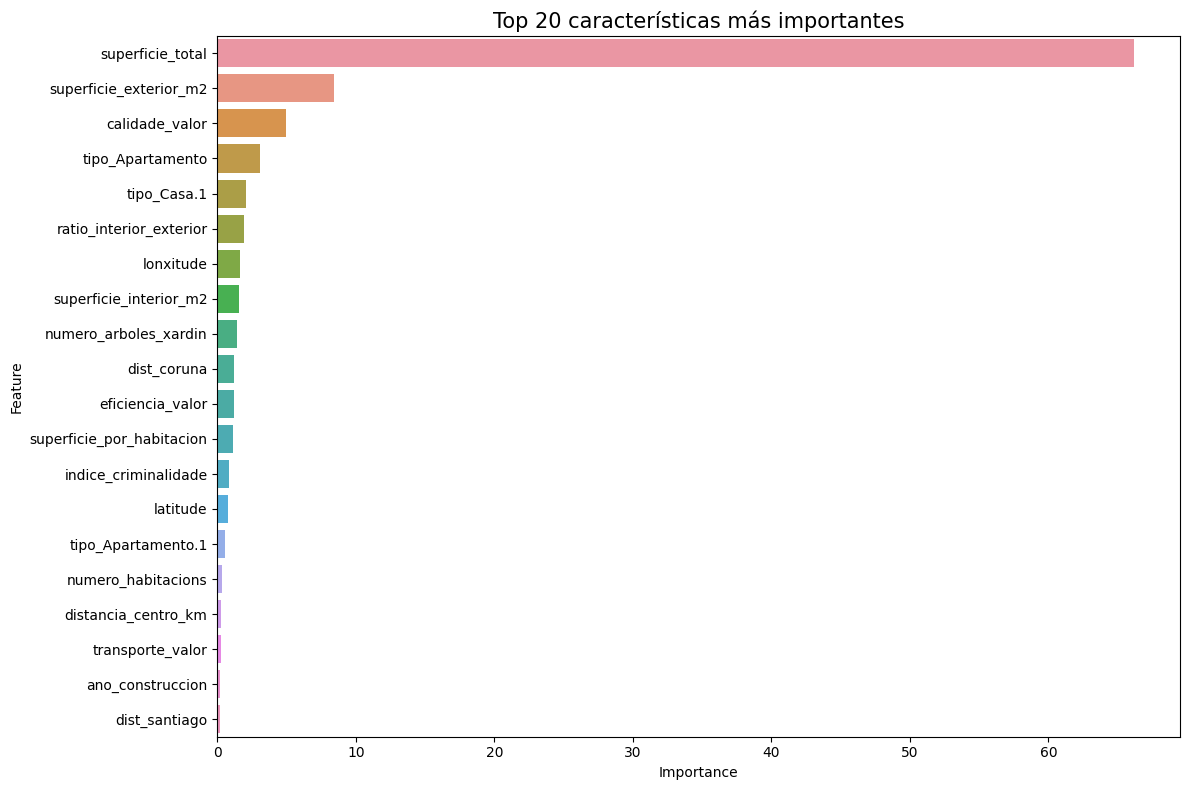

In [30]:
print("=== OPTIMIZACIÃN PROFUNDA DE CATBOOST PARA PREDICCIÃN DE PRECIOS INMOBILIARIOS ===\n")

# Cargar datos - ajusta la ruta al archivo CSV
X, y, cat_features = load_data('train_processed.csv')

# Fase 1: Entrenamiento inicial y anÃ¡lisis
initial_model, X_train, X_test, y_train, y_test, cat_features, importance_df = train_initial_model(X, y, cat_features)



initial_model.save_model('resultados_ayuda/mejor_modelo_inicial.cbm')
print("\nEl mejor modelo encontrado en la fase inicial ha sido guardado como 'resultados_ayuda/mejor_modelo_inicial.cbm'")

"""



# Fase 2: OptimizaciÃ³n con Grid Search
gs_model, gs_best_params = optimize_with_grid_search(X_train, y_train, X_test, y_test, cat_features)


# Evaluación final usando el modelo de Grid Search
# Predicciones con el modelo encontrado por Grid Search
y_pred_test = gs_model.predict(X_test)

# Calcular el MAE en el conjunto de validación (test)
mae_test = mean_absolute_error(y_test, y_pred_test)

# Imprimir el MAE en la validación
print(f"MAE en validación (test) con el mejor modelo encontrado por Grid Search: {mae_test:.2f}")



# Eliminar la parte de Optuna, ya que no se usará
# Fase 3: OptimizaciÃ³n con Optuna - ESTA FASE YA NO SE USA, ELIMINADA

# Guardar el mejor modelo encontrado en Grid Search
gs_model.save_model('resultados_ayuda/mejor_modelo_grid_search.cbm')
print("\nEl mejor modelo encontrado por Grid Search ha sido guardado como 'resultados_ayuda/mejor_modelo_grid_search.cbm'")

# Evaluación final usando el modelo de Grid Search
#error_analysis = evaluate_final_model(gs_model, X_train, X_test, y_train, y_test, cat_features)
"""
print("\n=== PROCESO DE OPTIMIZACIÓN COMPLETADO ===")
print(f"Los resultados y gráficos se han guardado en la carpeta 'resultados_ayuda'")
print(f"El mejor modelo de Grid Search se ha guardado como 'resultados_ayuda/mejor_modelo_grid_search.cbm'")

In [31]:

# Verificar la existencia del modelo entrenado
model_path = 'resultados_ayuda/mejor_modelo_inicial.cbm'
if not os.path.exists(model_path):
    print(f"¡Error! No se encuentra el modelo en {model_path}")
    print("Por favor, asegúrate de ejecutar primero el script de entrenamiento")
    exit(1)

print("=== Generando predicciones para el conjunto de prueba ===")

# Cargar el dataset de prueba
print("Cargando datos de prueba...")
test_df = pd.read_csv('test_processed.csv')

# Extraer los IDs para el submission
ids = test_df['id']

# Verificar características categóricas (usando las mismas que en entrenamiento)
categorical_features = []
for col in test_df.columns:
    if test_df[col].dtype == 'object' or col in ['tipo_edificacion', 'calidade_materiais', 
                                              'cor_favorita_propietario', 'acceso_transporte_publico',
                                              'orientacion', 'eficiencia_enerxetica']:
        categorical_features.append(col)

print(f"Características categóricas detectadas: {categorical_features}")

# Preparar los datos para la predicción (eliminar cualquier columna que no sea una feature)
X_test = test_df.drop(['id', 'Unnamed: 0'], axis=1, errors='ignore')
if 'prezo_euros' in X_test.columns:
    X_test = X_test.drop(['prezo_euros'], axis=1, errors='ignore')

print(f"Forma del dataset de prueba: {X_test.shape}")

# Cargar el modelo entrenado
print("Cargando el modelo entrenado...")
model = CatBoostRegressor()
model.load_model(model_path)

# Realizar predicciones
print("Generando predicciones...")
predictions = model.predict(X_test)

# Crear el dataframe de submission
submission = pd.DataFrame({
    'id': ids,
    'prezo_euros': predictions
})

# Guardar el archivo de submission
submission_path = 'submission_catboost_ayuda.csv'
submission.to_csv(submission_path, index=False)

print(f"¡Completado! Archivo de submission generado en {submission_path}")
print(f"Primeras filas del archivo de submission:")
print(submission.head(10))

# Estadísticas de las predicciones
print("\nEstadísticas de las predicciones:")
print(f"Mínimo: {predictions.min():.2f}")
print(f"Máximo: {predictions.max():.2f}")
print(f"Media: {predictions.mean():.2f}")
print(f"Mediana: {np.median(predictions):.2f}")
print(f"Desviación estándar: {predictions.std():.2f}")

=== Generando predicciones para el conjunto de prueba ===
Cargando datos de prueba...
Características categóricas detectadas: []
Forma del dataset de prueba: (10000, 45)
Cargando el modelo entrenado...
Generando predicciones...
¡Completado! Archivo de submission generado en submission_catboost_ayuda.csv
Primeras filas del archivo de submission:
      id    prezo_euros
0   2309  451341.843194
1  22405  145710.706368
2  23398  420838.399943
3  25059  274952.270052
4   2665  593694.552097
5   8512   73322.212260
6   5149  601496.335229
7   7791  272194.928448
8  11312  106847.052511
9  19044  316498.039409

Estadísticas de las predicciones:
Mínimo: 34910.29
Máximo: 823228.24
Media: 222397.51
Mediana: 151666.04
Desviación estándar: 163769.35
